# Prosjektoppgave MET2010

## Innholdsfotegnelse
1. Innledning
2. Datainnhenting og strukturering
3. Visualisering og deskriptiv statistikk
4. Simulasjon
5. 
6. 
7. Kilder
8. Ordtelling

## 1. Innledning

I denne prosjektoppgaven vil jeg ta for meg data knyttet til vær, stråling og forurensing i Trondheim, dette for å se en sammenheng mellom disse og også kunne predikere når det er høyest andel av svevestøv. Svevestøv er i dag et problem i byer, spesielt for personer med astma og andre luftveissykdommer, disse partiklene deles ofte inn i de to størrelsene PM2.5 og PM10 der partiklene er henholdsvis 2.5 og 10 µm. Ifølge FHI så vil begge disse størrelse

## 2. Datainnhenting

Starter med å importere de relevante pakkene, for deretter å innhente værdata fra Metrologisk institutt. Målingene er gjort på Voll målestasjon i Trondheim.

In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import shapiro

In [221]:
weather = pd.read_csv("data/Temperatur_regn.csv", sep=";", decimal=",")

In [222]:
weather.tail()

,Navn,Stasjon,Tid(norsk normaltid),Maksimumstemperatur (døgn),Minimumstemperatur (døgn),Høyeste middelvind (døgn),Nedbør (døgn)
2553,Trondheim - Voll,SN68860,28.12.2021,-4.5,-10.1,"1,6",0.0
2554,Trondheim - Voll,SN68860,29.12.2021,-4.5,-9.7,"2,4",0.0
2555,Trondheim - Voll,SN68860,30.12.2021,-0.4,-6.5,"2,9",0.0
2556,Trondheim - Voll,SN68860,31.12.2021,2.4,-1.9,"4,8",3.2
2557,"Data er gyldig per 16.11.2022 (CC BY 4.0), Met...",NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
weather.drop(weather.tail(1).index,inplace=True)

In [224]:
weather.rename(columns={"Navn" : "Station_Name"}, inplace=True)
weather.rename(columns={"Stasjon" : "StationID"}, inplace=True)
weather.rename(columns={"Tid(norsk normaltid)" : "Time"}, inplace=True)
weather.rename(columns={"Maksimumstemperatur (døgn)" : "Max_Temp"}, inplace=True)
weather.rename(columns={"Minimumstemperatur (døgn)" : "Min_Temp"}, inplace=True)
weather.rename(columns={"Høyeste middelvind (døgn)" : "Max_Wind"}, inplace=True)
weather.rename(columns={"Nedbør (døgn)" : "Rain"}, inplace=True)

Endrer navnet på kolonnene for lettere koding, unngår mellomrom av samme grunn.

In [225]:
weather.set_index("Time", inplace=True)
weather.index = pd.to_datetime(weather.index, format="%d.%m.%Y").date

Setter indeksen til dag ved bruk av pandas sin innebygde datetime funksjon. Formatet er europeisk med dag, måned, år. 

In [226]:
year = pd.DatetimeIndex(weather.index).year.to_numpy()
month = pd.DatetimeIndex(weather.index).month.to_numpy()

In [227]:
weather.insert(0, "Month", month)
weather.insert(1, "Year", year)

Legger til måned og år som variabler for å kunne se om tid på året påvirker de andre variablene.

In [228]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2557 entries, 2015-01-01 to 2021-12-31
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Month         2557 non-null   int64  
 1   Year          2557 non-null   int64  
 2   Station_Name  2557 non-null   object 
 3   StationID     2557 non-null   object 
 4   Max_Temp      2557 non-null   float64
 5   Min_Temp      2557 non-null   float64
 6   Max_Wind      2557 non-null   object 
 7   Rain          2557 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 179.8+ KB


Lager en variabel for daglig gjennomsnittstemperatur

In [229]:
mean_temp = (weather["Max_Temp"]+weather["Min_Temp"])/2

In [230]:
weather.insert(6, "Mean_Temp", mean_temp)

Bruker funksjonen insert for å legge til gjennomsnittstemperaturen ved siden av de andre temperaturvariablene.

In [231]:
weather["Is_Rain"] = np.where(weather.Rain>0, 1, 0)

Legger til en binomisk variabel for om det har regnet eller ikke.

In [232]:
weather["Max_Wind"] = weather.Max_Wind.str.replace(',','.')
weather["Max_Wind"] = weather.Max_Wind.str.replace('-','0')


Ser ovenfor at vindvariabelen har blitt importert som et object og ikke som et float-tall. Ser gjennom datasettet og finner at årsaken til dette er at vindstille er satt til "-" og ikke "0". I tillegg må desimalformen endres fra "," til ".", da dette ikke ble gjort ved importeringen. Omgjør deretter hele kolonnen til float64. 

In [233]:
weather["Max_Wind"] = weather.Max_Wind.astype("float64")

In [234]:
uv = pd.read_table("https://raw.githubusercontent.com/uvnrpa/Daily_Doses/master/TRH_daily.txt", skiprows=31)

Historisk UV-data er kun publisert som en txt-fil, det var derfor nødvendig å importere den med "read_table", selv om "read_fwf" også hadde vært en mulighet. Dette datasettet slutter 31 desember 2021, det var derfor bare å ta lengden av hoveddatasettet og kopiere dette ut fra bunnen av UV-datasettet. 

In [235]:
length_period = len(weather)

In [236]:
uv = uv.tail(length_period)

In [237]:
weather["UVA"] = uv["UVA"].to_numpy()
weather["UVB"] = uv["UVB"].to_numpy()

Velger å kun se på UVA og UVB stråling da de andre målingene i datasettet tar i større grad for seg biologiske faktorer som grad av fotosyntese og omgjøring av 7-DH7 til vitamin D3.

For å unngå NaN-verdier måtte pandas seriene gjøres om til numpy før det ble lagt til i hoveddatasettet. Dette har nok noe med forskjellen i indekseringen å gjøre. Dette steget gjentas gjennom databehandlingen.

In [238]:
weather.tail()

,Month,Year,Station_Name,StationID,Max_Temp,Min_Temp,Mean_Temp,Max_Wind,Rain,Is_Rain,UVA,UVB
2021-12-27,12,2021,Trondheim - Voll,SN68860,0.2,-7.3,-3.55,4.2,1.2,1,24021.0,57.144
2021-12-28,12,2021,Trondheim - Voll,SN68860,-4.5,-10.1,-7.30,1.6,0.0,0,23988.0,46.431
2021-12-29,12,2021,Trondheim - Voll,SN68860,-4.5,-9.7,-7.10,2.4,0.0,0,19061.0,32.673
2021-12-30,12,2021,Trondheim - Voll,SN68860,-0.4,-6.5,-3.45,2.9,0.0,0,24308.0,30.534
2021-12-31,12,2021,Trondheim - Voll,SN68860,2.4,-1.9,0.25,4.8,3.2,1,17993.0,19.491


In [239]:
weather = weather.drop("StationID", axis=1)

In [240]:
pressure = pd.read_csv("data/Lufttrykk.csv", sep=";", decimal=",")
pressure.drop(pressure.tail(1).index,inplace=True)

In [241]:
pressure.columns

Index(['Navn', 'Stasjon', 'Tid(norsk normaltid)',
       'Høyeste lufttrykk i havnivå (døgn)',
       'Laveste lufttrykk i havnivå (døgn)'],
      dtype='object')

In [242]:
weather["Max_Pressure"] = pressure["Høyeste lufttrykk i havnivå (døgn)"].to_numpy()
weather["Min_Pressure"] = pressure["Laveste lufttrykk i havnivå (døgn)"].to_numpy()

In [243]:
weather.tail()

,Month,Year,Station_Name,Max_Temp,Min_Temp,Mean_Temp,Max_Wind,Rain,Is_Rain,UVA,UVB,Max_Pressure,Min_Pressure
2021-12-27,12,2021,Trondheim - Voll,0.2,-7.3,-3.55,4.2,1.2,1,24021.0,57.144,1007.9,1002.2
2021-12-28,12,2021,Trondheim - Voll,-4.5,-10.1,-7.30,1.6,0.0,0,23988.0,46.431,1001.6,998.7
2021-12-29,12,2021,Trondheim - Voll,-4.5,-9.7,-7.10,2.4,0.0,0,19061.0,32.673,1000.6,996.8
2021-12-30,12,2021,Trondheim - Voll,-0.4,-6.5,-3.45,2.9,0.0,0,24308.0,30.534,996.4,987.3
2021-12-31,12,2021,Trondheim - Voll,2.4,-1.9,0.25,4.8,3.2,1,17993.0,19.491,1009.9,995.1


In [244]:
pollution = pd.read_csv("data/luftkvalitet.csv", skiprows=3)

In [245]:
pollution.isna().sum()

Tid                                   0
E6-Tiller PM10 µg/m³ Day            330
Dekning                               1
E6-Tiller PM2.5 µg/m³ Day           330
Dekning.1                             1
Elgeseter PM10 µg/m³ Day            132
Dekning.2                             1
Elgeseter PM2.5 µg/m³ Day           132
Dekning.3                             1
Elgeseter mobil PM10 µg/m³ Day     2514
Dekning.4                          2513
Elgeseter mobil PM2.5 µg/m³ Day    2514
Dekning.5                          2513
Omkjøringsvegen PM10 µg/m³ Day     1871
Dekning.6                          1427
Omkjøringsvegen PM2.5 µg/m³ Day    1892
Dekning.7                          1427
Torvet PM10 µg/m³ Day               268
Dekning.8                            35
Torvet PM2.5 µg/m³ Day              272
Dekning.9                            34
Åsveien skole PM10 µg/m³ Day       2121
Dekning.10                         2113
Åsveien skole PM2.5 µg/m³ Day      2121
Dekning.11                         2113


Velger å bruke målestasjonen i Elgeseter ettersom denne har færrest NaN-verdier, i tillegg til at det er den det er mest relevant å se på som følge av sin nærhet til Adolf Øien bygget. Grunnen til disse NaN-verdiene kan være manglende dekningen på målestasjonene. For å få fullstendige data velger jeg å fylle disse verdiene med målinger fra andre stasjoner i nærheten, jeg velger hovedsaklig de med likest lokasjon og omgivelser og unnlater å ta med målinger ved E6. De verdiene som fremdeles manglet etter dette fylte jeg først ved å ta snittet av den forrige og den neste verdien, dette vil føre til et någenlunde greit estimat for de fem dagene det gjelder. Til slutt fyllte jeg den siste verdien med den nest siste. 

In [246]:
pollution['Elgeseter PM10 µg/m³ Day'].fillna(pollution['Torvet PM10 µg/m³ Day'], inplace=True)
print(pollution["Elgeseter PM10 µg/m³ Day"].isna().sum())
pollution['Elgeseter PM10 µg/m³ Day'].fillna(pollution['Bakke kirke PM10 µg/m³ Day'], inplace=True)
print(pollution["Elgeseter PM10 µg/m³ Day"].isna().sum())
pollution['Elgeseter PM10 µg/m³ Day'].fillna(pollution['Åsveien skole PM10 µg/m³ Day'], inplace=True)
print(pollution["Elgeseter PM10 µg/m³ Day"].isna().sum())
pollution["Elgeseter PM10 µg/m³ Day"] = (pollution["Elgeseter PM10 µg/m³ Day"].ffill()+pollution["Elgeseter PM10 µg/m³ Day"].bfill())/2
print(pollution["Elgeseter PM10 µg/m³ Day"].isna().sum())
pollution["Elgeseter PM10 µg/m³ Day"].ffill(inplace=True)
print(pollution["Elgeseter PM10 µg/m³ Day"].isna().sum())

27
13
6
1
0


In [247]:
pollution['Elgeseter PM2.5 µg/m³ Day'].fillna(pollution['Torvet PM2.5 µg/m³ Day'], inplace=True)
pollution['Elgeseter PM2.5 µg/m³ Day'].fillna(pollution['Bakke kirke PM2.5 µg/m³ Day'], inplace=True)
pollution['Elgeseter PM2.5 µg/m³ Day'].fillna(pollution['Åsveien skole PM2.5 µg/m³ Day'], inplace=True)
pollution["Elgeseter PM2.5 µg/m³ Day"] = (pollution["Elgeseter PM2.5 µg/m³ Day"].ffill()+pollution["Elgeseter PM2.5 µg/m³ Day"].bfill())/2
pollution["Elgeseter PM2.5 µg/m³ Day"].ffill(inplace=True)
print(pollution["Elgeseter PM2.5 µg/m³ Day"].isna().sum())

0


In [248]:
weather["Pollution_PM25"] = pollution["Elgeseter PM2.5 µg/m³ Day"].to_numpy()
weather["Pollution_PM10"] = pollution["Elgeseter PM10 µg/m³ Day"].to_numpy()

In [249]:
power2015 = pd.read_csv("data/poweruse_2015.csv")
power2016 = pd.read_csv("data/poweruse_2016.csv")
power2017 = pd.read_csv("data/poweruse_2017.csv")
power2018 = pd.read_csv("data/poweruse_2018.csv")
power2019 = pd.read_csv("data/poweruse_2019.csv")
power2020 = pd.read_csv("data/poweruse_2020.csv")
power2021 = pd.read_csv("data/poweruse_2021.csv")

In [250]:
power_list = [power2015, power2016, power2017, power2018, power2019, power2020, power2021]

In [251]:
daily_power = pd.DataFrame()
daily_power = pd.concat(power_list, ignore_index=True)

In [252]:
daily_power.drop(daily_power.head(3).index,inplace=True)
daily_power.drop(daily_power.tail(2).index,inplace=True)
daily_power.reset_index(inplace=True)

In [253]:
weather_power = weather.copy()

In [254]:
weather_power["Max_Power"] = daily_power["Max Total Load [MW] - BZN|NO3"].to_numpy()
weather_power["Min_Power"] = daily_power["Min Total Load [MW] - BZN|NO3"].to_numpy()

In [255]:
weather_power.to_csv("data/weather_power_TRD.csv")

## 3. Visualisering og deskriptiv statistikk

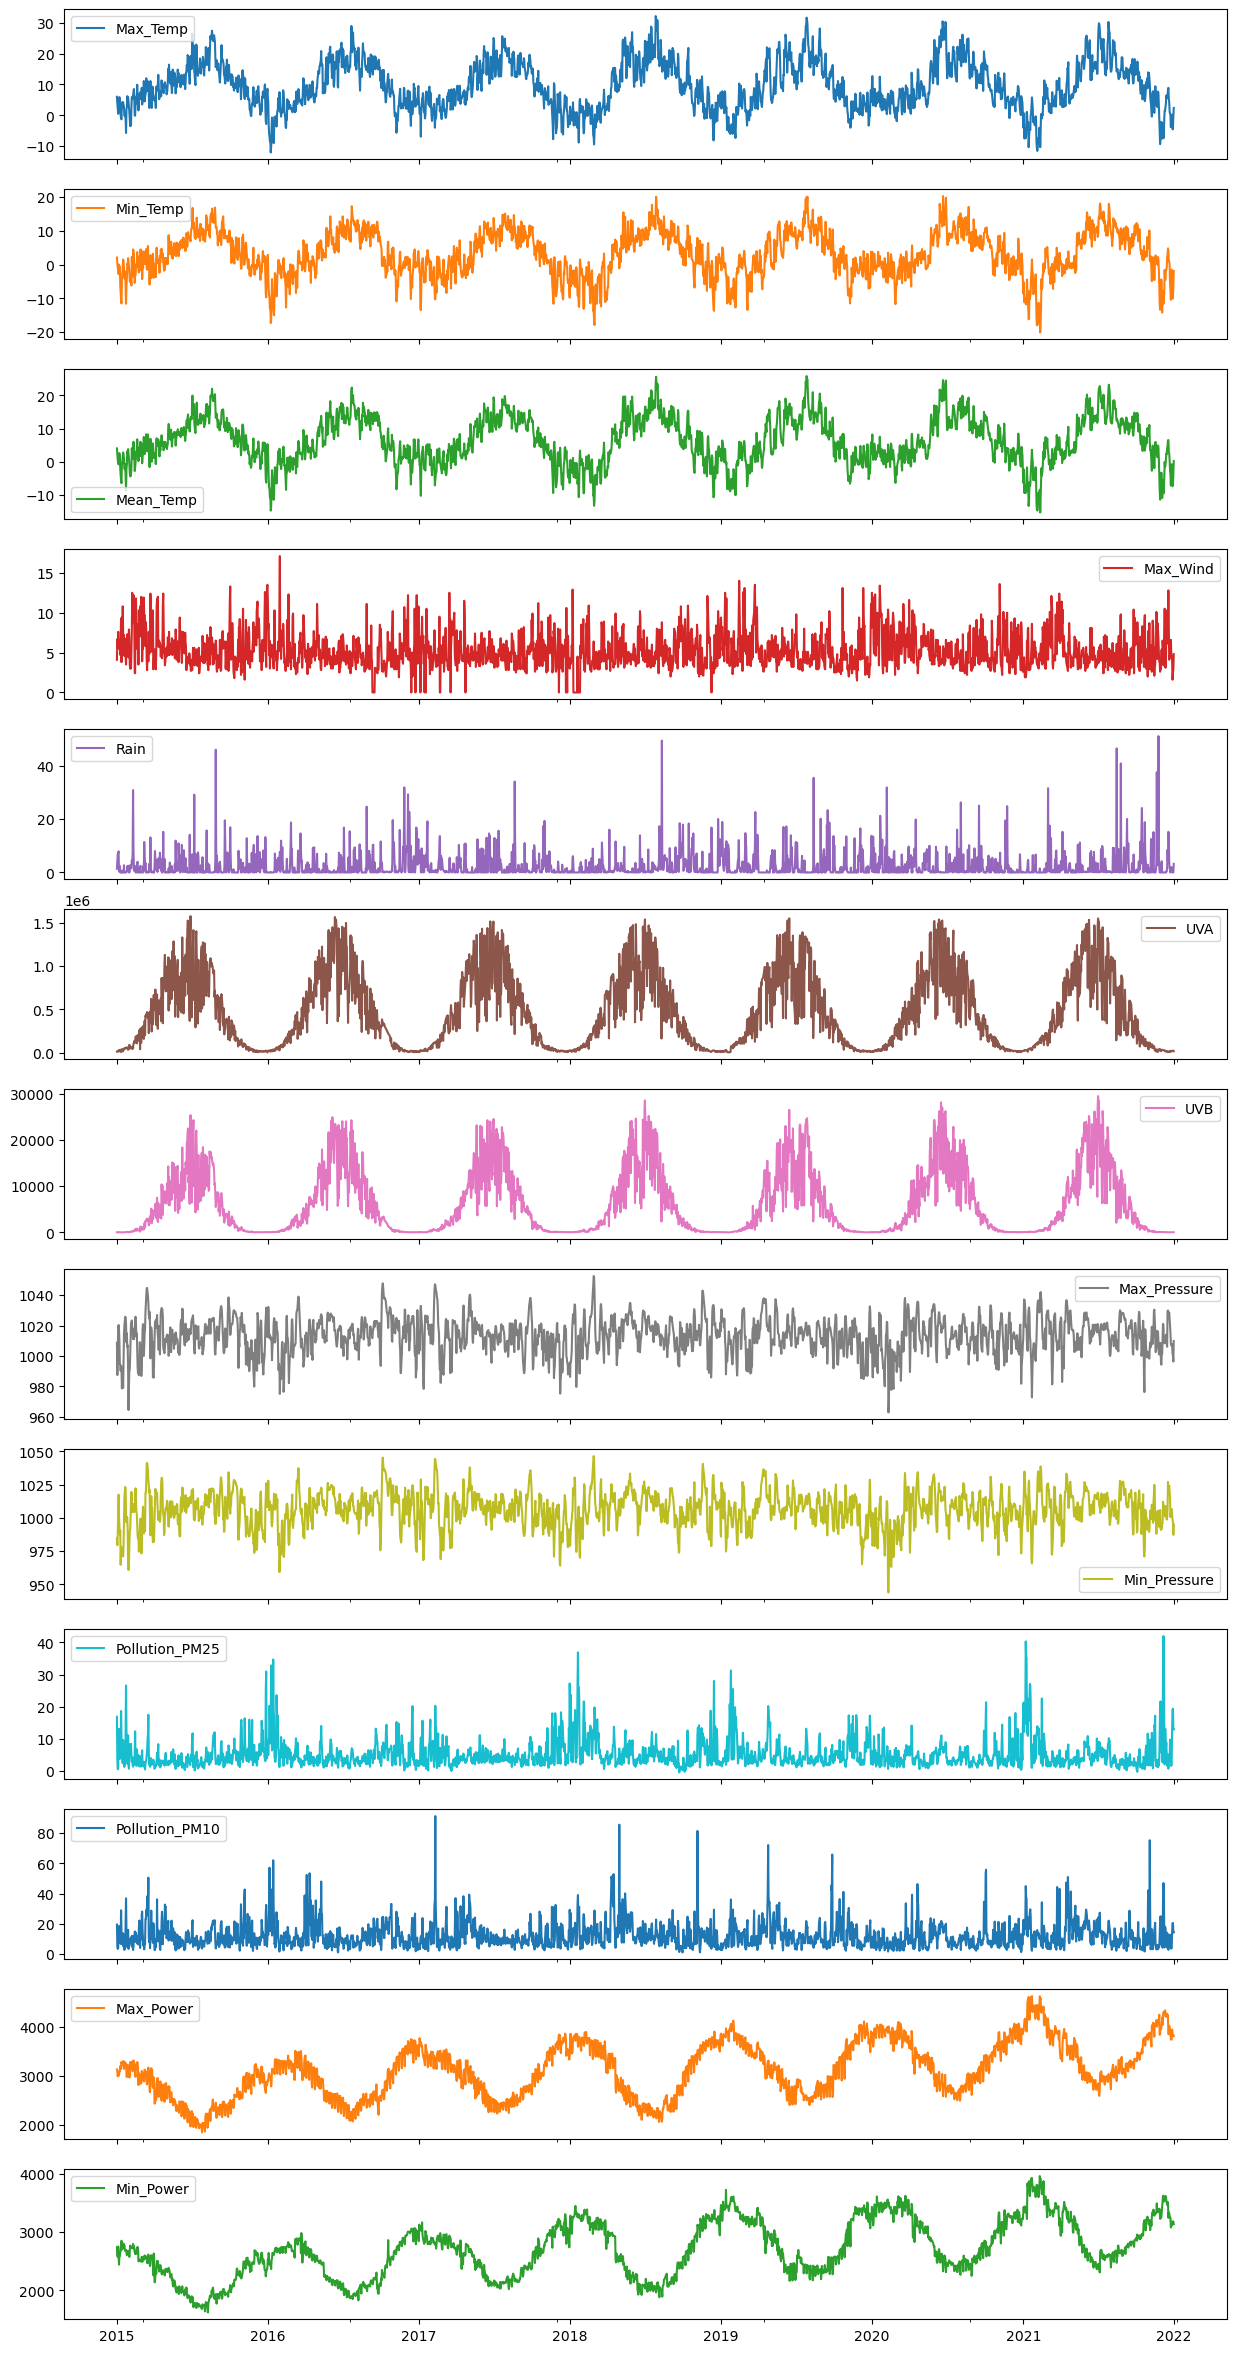

In [256]:
weather_power.drop(["Is_Rain", "Year","Month"],axis=1).plot(subplots = True, figsize=(15,30))
plt.show()

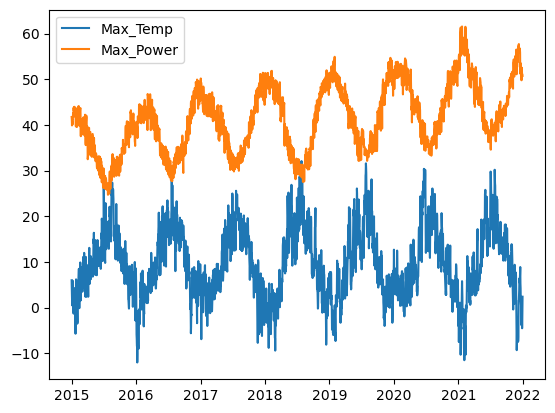

In [257]:
weather_power.Max_Temp.plot()
(weather_power.Max_Power/75).plot()
plt.legend()
plt.show()

En enkel måte å vise den iverse sammenhengen mellom maksimal temperatur og maksimal strømforbruk i løpet av dagen. Dette er ikke overraskende da mesteparten av strømforbruken i en husholdning går til oppvarming. 

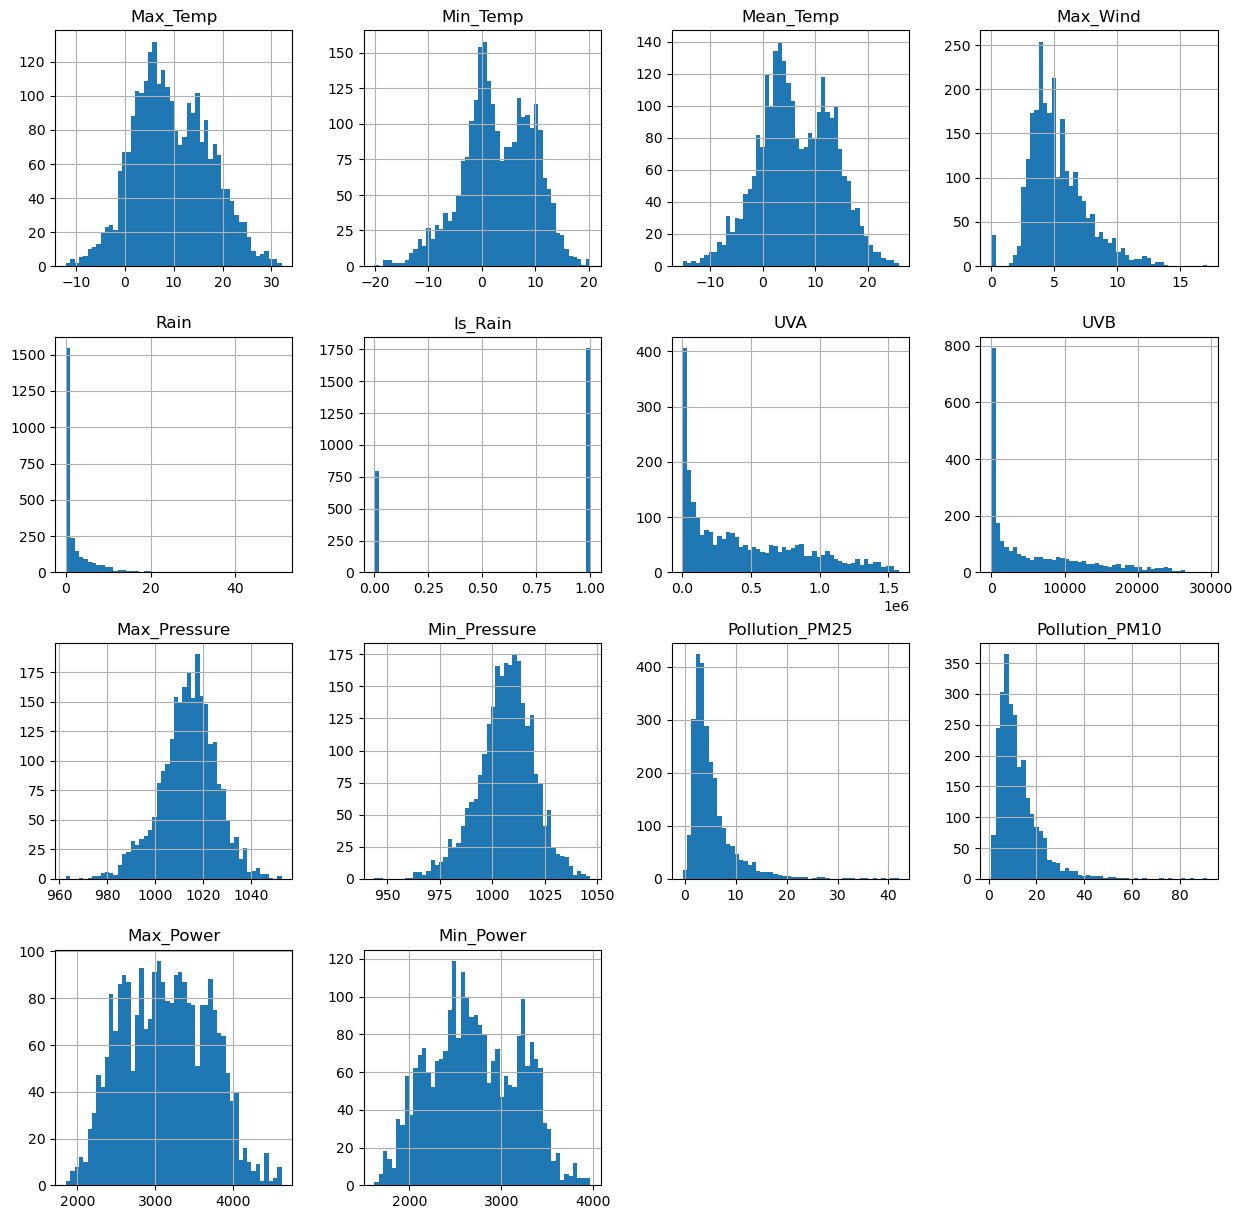

In [258]:
weather_power.drop(["Year", "Month"], axis=1).hist(bins=50, figsize=(15,15))
plt.show()

Gjennom dette histogrammet kan en se at begge målenhetene for forurensing har en positiv skjevhet(skewness), de er samlet forholdsvis lavt med noen høyere ytterpunkter. Muligens ikke så overraskende for de som har bodd i Trondheim ser en at det regner nesten dobbelt så mange dager enn det har vært opphold, men samtidig har også dette en positiv skjevhet, noe som innebærer at det ikke har vært for høy nedbør når det har regnet. Videre kan det se ut som at de andre variablene er relativt normalfordelt, i tillegg til noen bimodale fordelinger.

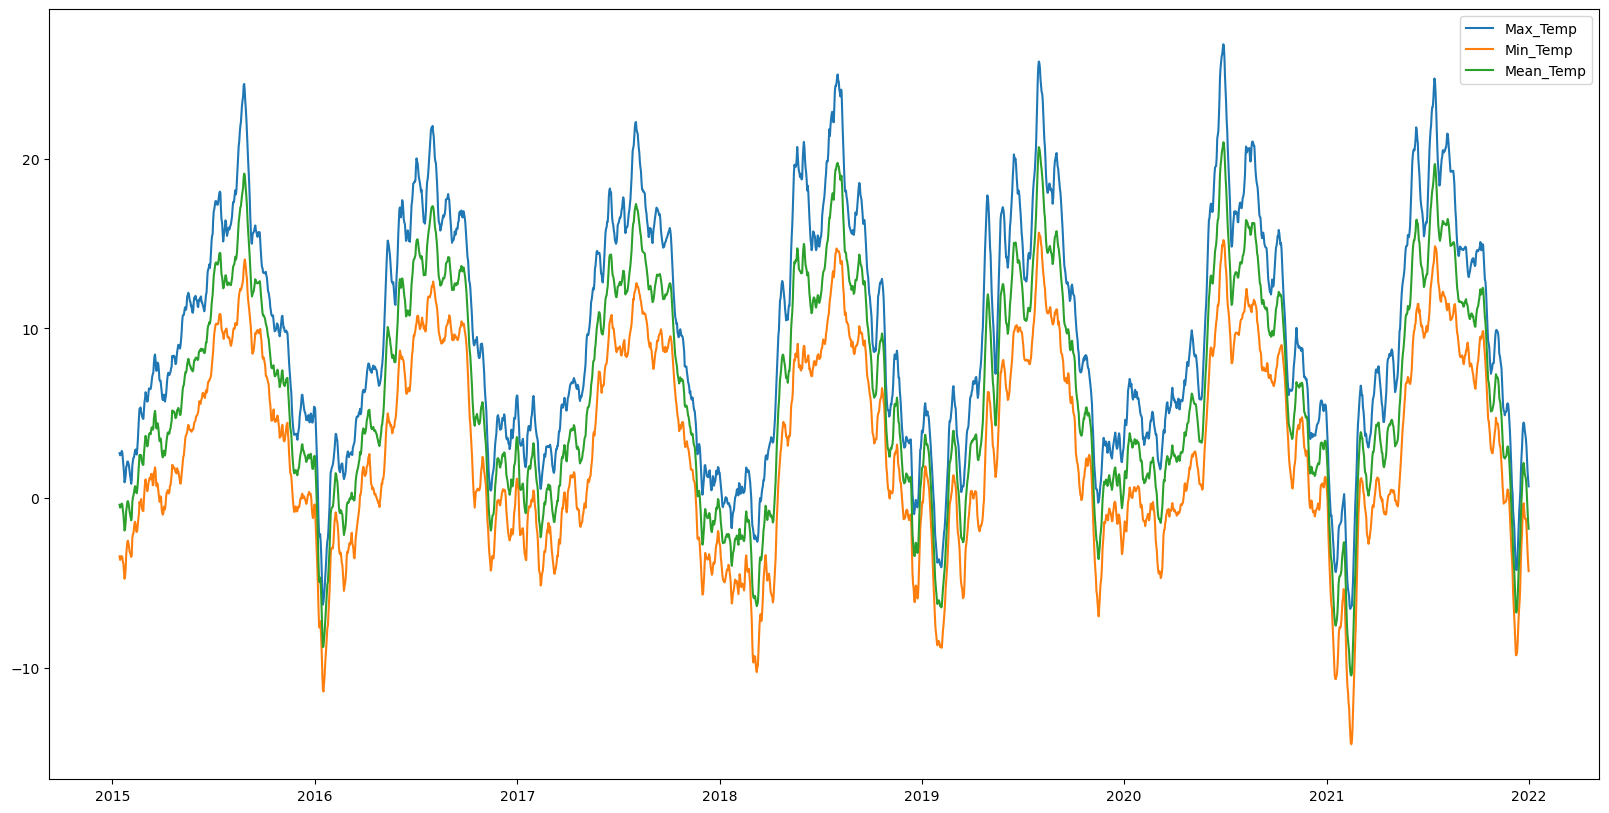

In [259]:
weather_power.Max_Temp.rolling(14).mean().plot(figsize=(20,10))
weather_power.Min_Temp.rolling(14).mean().plot()
weather_power.Mean_Temp.rolling(14).mean().plot()

plt.legend()
plt.show()

In [260]:
weather_power.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Month,2557.0,6.522487,3.449499,1.00000,4.000000,7.000000,10.000000,1.200000e+01
Year,2557.0,2018.000000,2.000391,2015.00000,2016.000000,2018.000000,2020.000000,2.021000e+03
Max_Temp,2557.0,9.636840,7.696523,-12.00000,4.000000,8.800000,15.200000,3.210000e+01
Min_Temp,2557.0,3.079937,6.585082,-20.10000,-1.100000,2.800000,8.300000,2.030000e+01
Mean_Temp,2557.0,6.358389,6.993643,-15.20000,1.450000,5.700000,11.800000,2.580000e+01
Max_Wind,2557.0,5.286117,2.227827,0.00000,3.800000,4.800000,6.400000,1.710000e+01
Rain,2557.0,2.453109,4.634751,0.00000,0.000000,0.400000,2.900000,5.100000e+01
Is_Rain,2557.0,0.688698,0.463117,0.00000,0.000000,1.000000,1.000000,1.000000e+00
UVA,2557.0,461903.896402,419709.313856,3683.10000,77954.000000,347970.000000,772490.000000,1.575500e+06
UVB,2557.0,6067.404159,6915.824940,-20.35200,303.030000,3126.500000,10185.000000,2.947300e+04


In [261]:
days_above_limit_num = weather_power.Pollution_PM10.where(weather_power.Pollution_PM10>50).sort_values(ascending=False).count()
days_above_limit = weather_power.Pollution_PM10.where(weather_power.Pollution_PM10>50).sort_values(ascending=False).head(days_above_limit_num)
print("Antall overskridelser av døgnmiddel på 50 µg/m3:", days_above_limit_num, "\nDette inntraff følgende dager med døgnmiddel:\n", days_above_limit)

Antall overskridelser av døgnmiddel på 50 µg/m3: 16 
Dette inntraff følgende dager med døgnmiddel:
 2017-02-09    91.250005
2018-04-30    85.571233
2018-11-05    81.436170
2021-11-03    75.269673
2019-04-25    72.108251
2019-09-27    65.834444
2016-01-14    62.022458
2016-01-05    57.150666
2020-10-03    55.797206
2016-04-11    53.456952
2020-10-02    53.242974
2018-04-16    52.881548
2016-04-04    52.330207
2018-04-11    51.291155
2021-04-19    50.960609
2015-03-18    50.566502
Name: Pollution_PM10, dtype: float64


Grenseverdien på 50µg/m3 ble oversteget totalt 16 ganger i løpet av seks år, dette er langt under grensen på 25 ganger per år. Likevel er det relevant å se hvilke dager dette er og se hvilke faktorer som gjorde at graden av svevestøv var høyere enn normalt.

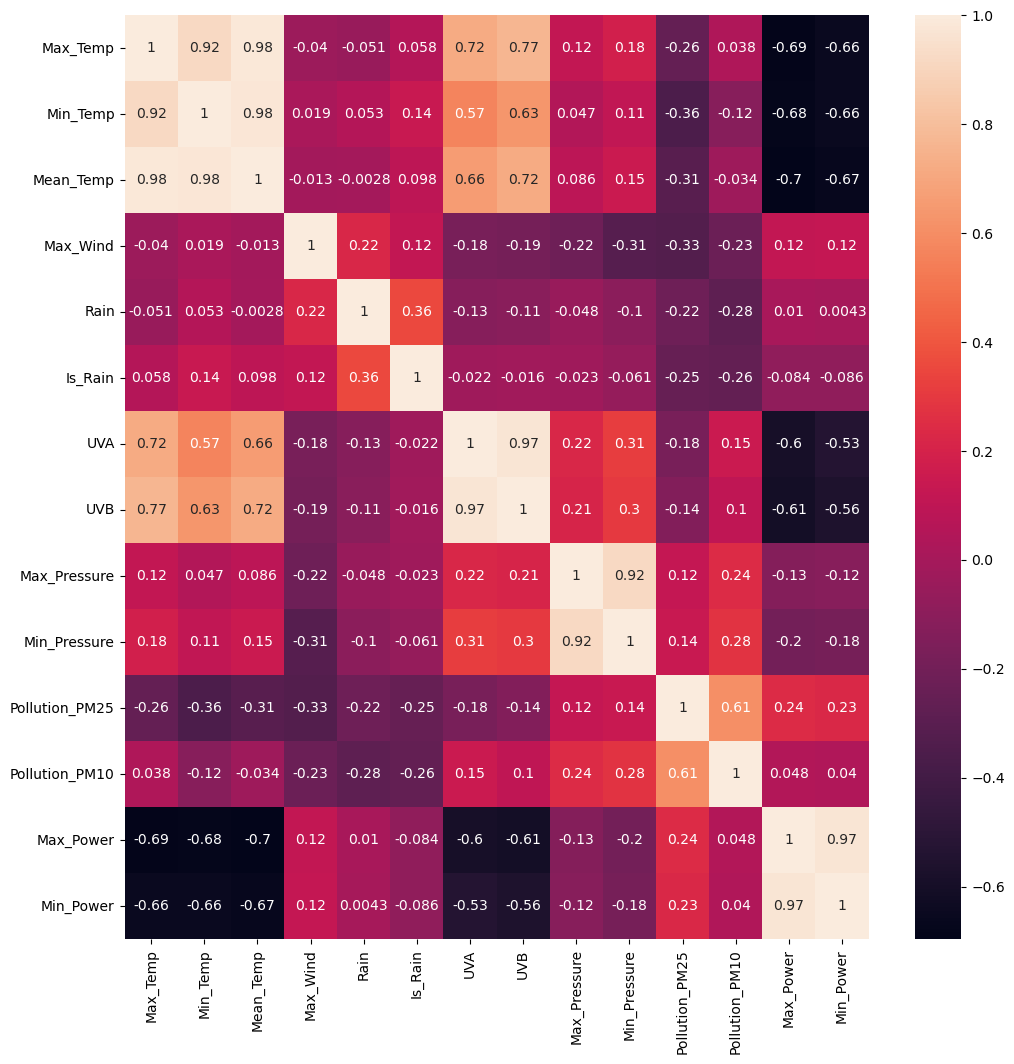

In [262]:
plt.figure(figsize=(12,12))
sns.heatmap(weather_power.drop(["Year", "Month"], axis=1).corr(numeric_only=True), annot=True)
plt.show()

In [263]:
diff_Temp = weather_power.Max_Temp - weather_power.Min_Temp

In [264]:
diff_Temp.describe()

count    2557.000000
mean        6.556903
std         3.091183
min         0.800000
25%         4.200000
50%         5.900000
75%         8.400000
max        19.000000
dtype: float64

In [265]:
diff_Temp.sort_values(ascending=False).head(15)

2018-05-08    19.0
2018-05-27    17.7
2020-06-12    17.4
2019-04-23    17.3
2021-06-01    17.3
2016-06-20    17.1
2021-07-26    17.1
2018-07-27    17.0
2018-05-30    16.8
2019-04-22    16.6
2018-07-05    16.2
2020-07-26    16.0
2021-08-06    16.0
2019-04-20    15.9
2021-07-04    15.9
dtype: float64

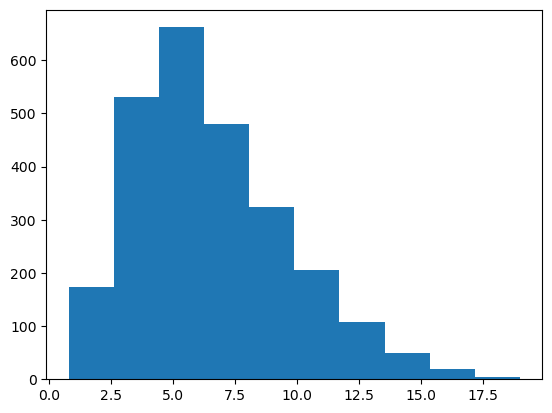

In [266]:
plt.hist(diff_Temp)
plt.show()

Ser her at forskjellen mellom minimum og maksimumstemperatur gjennom fra 2015 til 2021 lå mellom 0,8 og 19 grader med et snitt på 6,55. Ser også her at histogrammet er relativt skjevfordelt med en positiv skjevhet. Dette innebærer at det vanligvis vil være temperaturforskjell under snittet, men at det inntreffer dager hvor det er større forskjeller. De største temperaturforskjellene inntraff i mai 2018. 

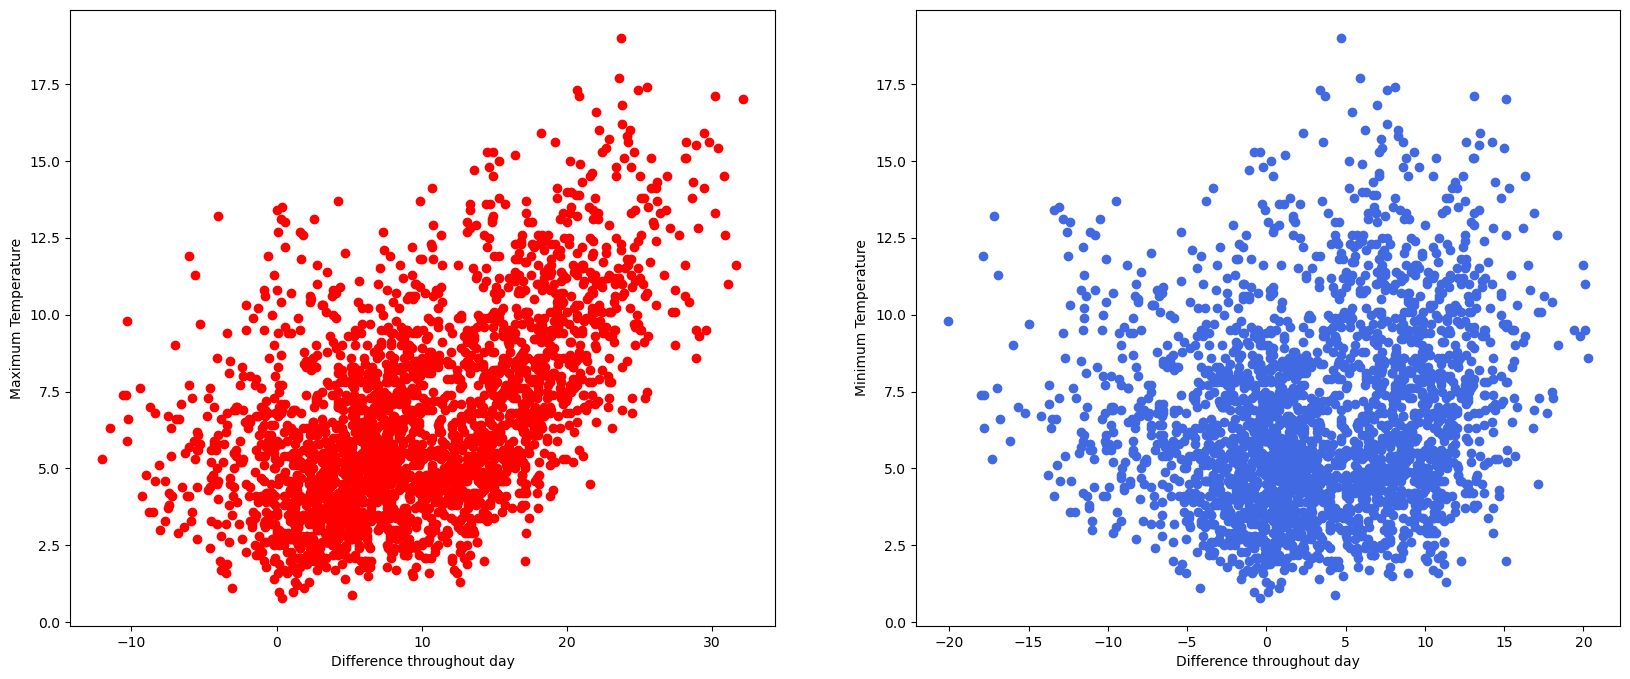

In [267]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.scatter(weather_power.Max_Temp, diff_Temp, color="red")
ax2.scatter(weather_power.Min_Temp, diff_Temp, color="royalblue")
ax1.set_ylabel('Maximum Temperature')
ax1.set_xlabel('Difference throughout day')
ax2.set_ylabel('Minimum Temperature')
ax2.set_xlabel('Difference throughout day')
plt.show()


Ser med disse grafene at korrelasjonen mellom temperaturforskjell og temperatur er høyest de dagene den maksimale temperaturen er høy. Dette tyder på at det er den høye dagstemperaturen som drar forskjellen opp. Kan også se dette med en enkel korrelasjonsmatrise.

In [268]:
max_corr = np.corrcoef([weather_power.Max_Temp, diff_Temp])
min_corr = np.corrcoef([weather_power.Min_Temp, diff_Temp])

print("Korrelasjon mellom maksimumstemperatur og temperaturforskjell er:", max_corr[1,0], 
"til forskjell fra korrelasjonen mellom temperaturforskjell og minimumstemperaturen som er:", 
min_corr[1,0])

Korrelasjon mellom maksimumstemperatur og temperaturforskjell er: 0.5344076235487902 til forskjell fra korrelasjonen mellom temperaturforskjell og minimumstemperaturen som er: 0.15518375266509873


## 4. "Fake"-data Simulasjon

### Normalfordeling

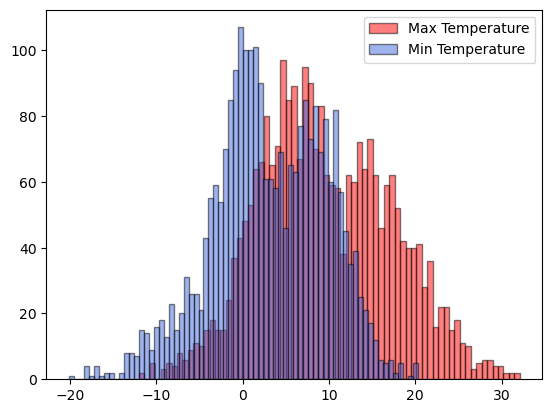

In [269]:
plt.hist(weather_power.Max_Temp, label='Max Temperature', alpha=0.5, color="red", bins=70, edgecolor='black')
plt.hist(weather_power.Min_Temp, label='Min Temperature', alpha=0.5, color="royalblue", bins=70, edgecolor='black')

plt.legend()

plt.show()

Ved å legge inn både daglige maksimum og minimums verdier i et histogram kan en tenke at fordelingen ikke er normalfordelt, men heller har to ditinkte topper. Dette kan vises testes ved å kjøre en simulasjon. Velger å se på minimumstemperaturen.

In [270]:
min_temp_mean = weather_power.Min_Temp.mean()
min_temp_std = weather_power.Min_Temp.std()

print(min_temp_mean, min_temp_std)

3.079937426671881 6.585082396464526


In [271]:
n=100000
min_temp_sim = np.random.normal(min_temp_mean, min_temp_std, n)

normEst = np.sum(min_temp_sim>10)/n

realProp = np.sum(weather_power.Min_Temp>10)/weather_power.Min_Temp.count()

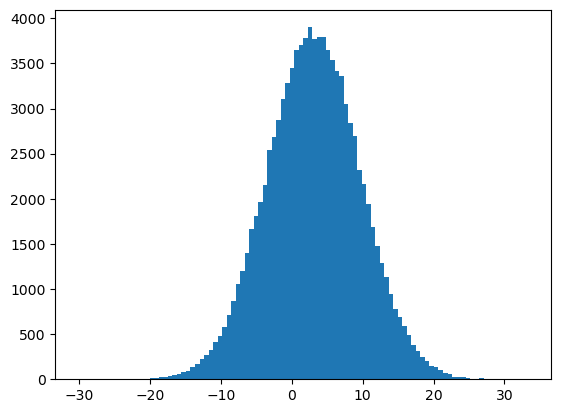

In [272]:
plt.hist(min_temp_sim, bins=100)
plt.show()

In [273]:
normEst

0.14474

In [274]:
realProp

0.16112631990614001

In [275]:
realProp/normEst

1.1132121038147023

Ser med simulasjonen at antallat tilfeller med minimumstemperatur ved simulasjonen ikke er langt unna det reelle antallet tilfeller. Derimot kan en se på histogrammet av simulasjonen at den ser klart annerledes ut enn histogrammet av den reelle temperaturen. <br>
<br>
Velger å kjøre en Shapiro-Wilk test for å vise klart at den ikke er normalfordelt.

In [276]:
stat, p = shapiro(weather_power.Max_Temp)
print('Resultat av testen =', stat, 'p=', round(p,5))

a = 0.05
if p > a:
	print('Minimumstemperaturen er normalfordelt.')
else:
	print('Minimumstemperaturen er ikke normalfordelt.')


Resultat av testen = 0.9926794767379761 p= 0.0
Minimumstemperaturen er ikke normalfordelt.


## 7. Kilder
UV-data hentet fra: https://github.com/uvnrpa/Daily_Doses \
Takk til DSA, NILU og UIO som tilbyr dette gratis. \
\
Fakta knyttet til svevestøv hentet fra: https://www.fhi.no/nettpub/luftkvalitet/temakapitler/svevestov/

## 8. Word Count

In [277]:
import json

with open('Prosjektoppgave.ipynb') as json_file:
    data = json.load(json_file)

wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] 
            wordCount = wordCount + len(temp)
            
print("Antall ord ekskludert kodeblokker:", wordCount)

Antall ord ekskludert kodeblokker: 914
